## Effect of Magnetic Field

/tmp/ipykernel_14643/92987425.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
0         186.973221
1         183.876816
2         183.820312
4         189.086685
5         187.996735
             ...    
144128    352.840000
144129    357.174000
144130      6.079566
144132    157.601672
144133    157.880328
Name: RA, Length: 116978, dtype: float64


/tmp/ipykernel_14643/92987425.py:142: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  deflection_map = hp.smoothing(deflection_map, fwhm=fwhm_rad, verbose=False)


[19.41020499 17.35490249 17.0816286  ... 44.27147951 41.70970916
 40.53049173]


<Figure size 1000x600 with 0 Axes>

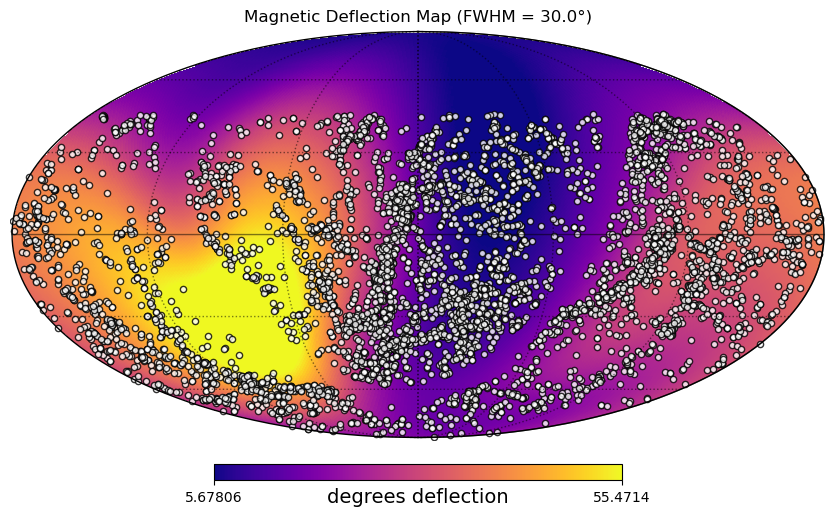

Median deflection = 24.081
High-deflection galaxies: 3081
Low-deflection galaxies:  3096
Randoms valid after deflection mask: 617700
High-deflection randoms: 397077
Low-deflection randoms:  220623


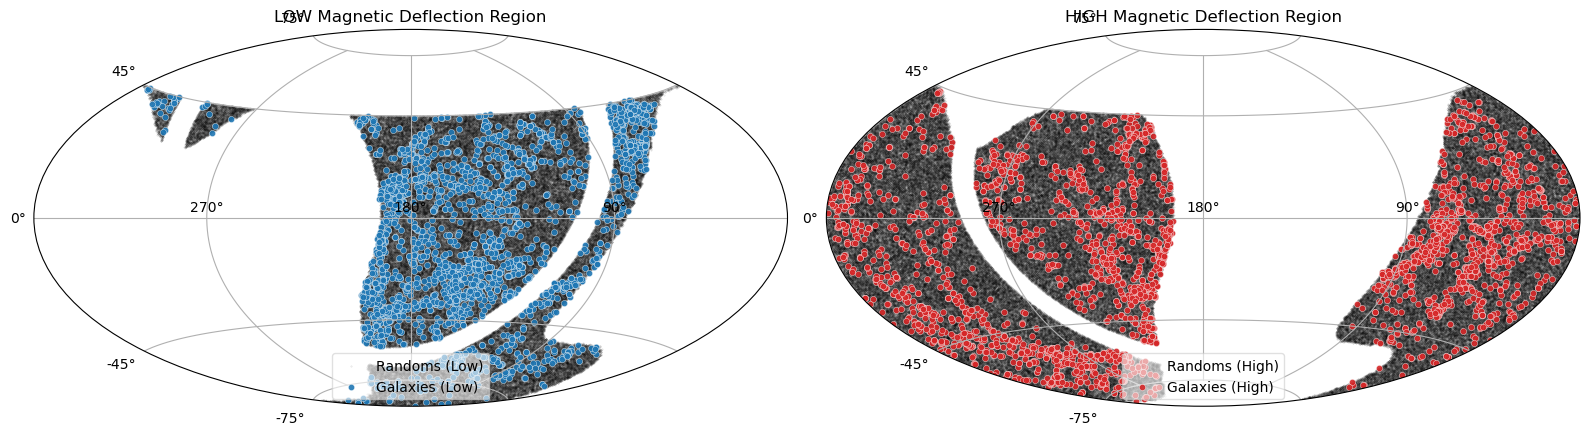

The following patch numbers have no objects: {34, 469, 166, 230}
This may be a problem depending on your use case.
The following patch numbers have no objects: {34, 469, 166, 230}
This may be a problem depending on your use case.


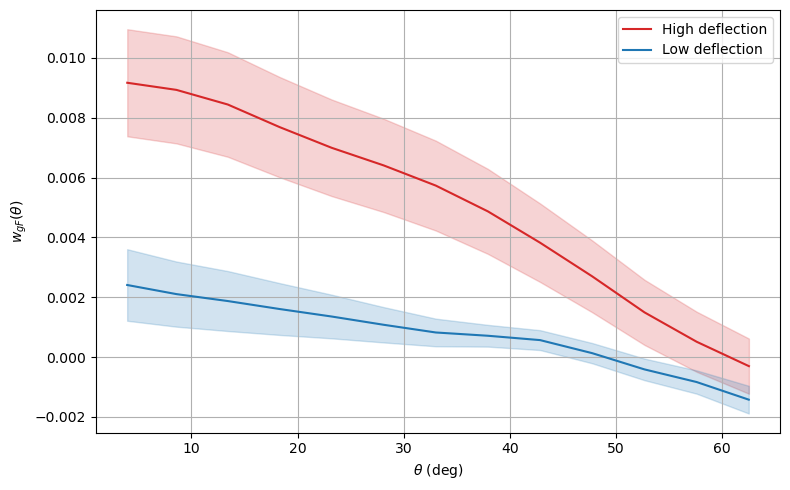

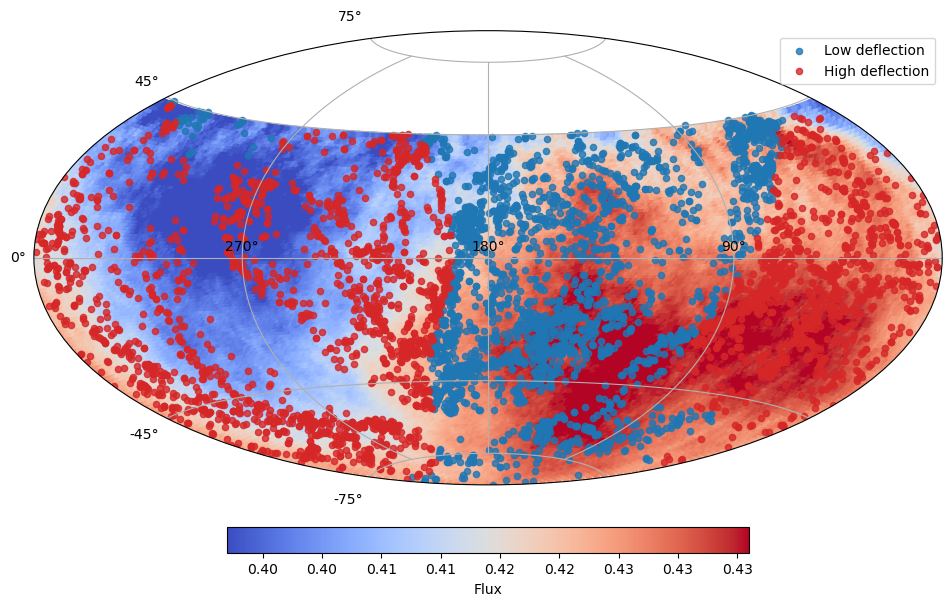

In [12]:
"""
GALAXY–FLUX CORRELATION SPLIT BY MAGNETIC DEFLECTION
"""
def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec']<45.]

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

def plot_magnetic_deflection(deflection_map, gxs_K):
    # === Plot smoothed magnetic deflection map ===
    plt.figure(figsize=(10, 6))
    hp.mollview(
        deflection_map,
        title=f"Magnetic Deflection Map (FWHM = {fwhm_deg:.1f}°)",
        unit="degrees deflection",
        cmap="plasma",
        rot=(180, 0, 0),
        min=np.percentile(deflection_map[deflection_map != hp.UNSEEN], 5),
        max=np.percentile(deflection_map[deflection_map != hp.UNSEEN], 95),
    )
    hp.graticule(dpar=30, dmer=60, alpha=0.5)

    # Overlay galaxies as points
    theta = -np.radians(90 - gxs_K["Dec"])
    phi = np.radians(gxs_K["RA"]) + np.pi
    hp.projscatter(theta, phi, lonlat=False, s=20, color="white", edgecolor='k', alpha=.8)

    plt.savefig("../plots/magnetic_deflection_map.png", dpi=300, bbox_inches="tight")
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.ticker import FormatStrFormatter
import treecorr
import healpy as hp
from astropy.io import ascii
import pandas as pd

# === User parameters ===
defl_file = "../data/JF12_GMFdeflection_Z1_E10EeV.csv"
fwhm_deg = 30.0
nrand = 100

# === Load Galaxies ===
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"
]
gxs = read_GLADE(cols)
print(gxs['RA'])
if gxs['RA'].max() <= 2*np.pi:
    gxs['RA'] = np.degrees(gxs['RA'])
    gxs['Dec'] = np.degrees(gxs['Dec'])
    print("Converted RA/Dec from radians to degrees.")
gxs = gxs[gxs['M_K'] < -20.0]  # Apply absolute magnitude cut
gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]  # cz cut

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)
flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]

# === Load / prepare deflection map ===
data = ascii.read(defl_file)
pixel_ids = data['pixid']
deflection_data = data['deflection']
npix = int(np.max(pixel_ids)) + 1
nside = hp.npix2nside(npix)
deflection_map = np.full(npix, hp.UNSEEN)
deflection_map[pixel_ids] = deflection_data

# Smooth map
if fwhm_deg and fwhm_deg > 0:
    fwhm_rad = np.radians(fwhm_deg)
    deflection_map = hp.smoothing(deflection_map, fwhm=fwhm_rad, verbose=False)


# === Assign each galaxy a deflection value ===
theta = np.radians(90 - gxs_K['Dec'])
phi = np.radians(gxs_K['RA'])
pix = hp.ang2pix(nside, theta, phi)
gal_defl = deflection_map[pix]

# Filter out unseen regions
valid = gal_defl != hp.UNSEEN
gxs_K = gxs_K[valid]
gal_defl = gal_defl[valid]
print(gal_defl)
plot_magnetic_deflection(deflection_map, gxs_K)


# === Classify galaxies by median deflection ===
median_defl = np.median(gal_defl)
#median_defl = np.percentile(gal_defl, 70)
mask_high = gal_defl > median_defl
mask_low = gal_defl <= median_defl

gxs_high = gxs_K[mask_high]
gxs_low = gxs_K[mask_low]

print(f"Median deflection = {median_defl:.3f}")
print(f"High-deflection galaxies: {len(gxs_high)}")
print(f"Low-deflection galaxies:  {len(gxs_low)}")

# === Apply deflection mask to the flux map, exactly like galaxies/randoms ===

# Convert flux RA/Dec to theta/phi
theta_f = np.radians(90 - flux_dec)
phi_f   = np.radians(flux_ra)
pix_f   = hp.ang2pix(nside, theta_f, phi_f)

# Read deflection at flux positions
flux_defl = deflection_map[pix_f]

# Keep only flux points in valid deflection region
valid_f = flux_defl != hp.UNSEEN

flux_dec = flux_dec[valid_f]
flux_ra  = flux_ra[valid_f]
flux_val = flux_val[valid_f]
flux_defl = flux_defl[valid_f]

# Split flux map into high/low using the SAME median from galaxies
mask_high_f = flux_defl > median_defl
mask_low_f  = flux_defl <= median_defl

flux_dec_high = flux_dec[mask_high_f]
flux_ra_high  = flux_ra[mask_high_f]
flux_val_high = flux_val[mask_high_f]

flux_dec_low  = flux_dec[mask_low_f]
flux_ra_low   = flux_ra[mask_low_f]
flux_val_low  = flux_val[mask_low_f]


# === Generate random catalog ===
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*nrand, dec_min=-90, dec_max=45)

# === Apply the deflection mask to the randoms ===
theta_r = np.radians(90 - rand_dec)
phi_r = np.radians(rand_ra)
pix_r = hp.ang2pix(nside, theta_r, phi_r)

rand_defl = deflection_map[pix_r]
valid_r = rand_defl != hp.UNSEEN

# Keep only valid randoms
rand_ra = rand_ra[valid_r]
rand_dec = rand_dec[valid_r]
rand_defl = rand_defl[valid_r]

# Split randoms using galaxy median deflection
mask_high_r = rand_defl > median_defl
mask_low_r  = rand_defl <= median_defl

rand_ra_high  = rand_ra[mask_high_r]
rand_dec_high = rand_dec[mask_high_r]

rand_ra_low   = rand_ra[mask_low_r]
rand_dec_low  = rand_dec[mask_low_r]

print(f"Randoms valid after deflection mask: {len(rand_ra)}")
print(f"High-deflection randoms: {len(rand_ra_high)}")
print(f"Low-deflection randoms:  {len(rand_ra_low)}")

def plot_deflection_sky_panels(
    gxs_low, gxs_high,
    rand_ra_low, rand_dec_low,
    rand_ra_high, rand_dec_high,
    savepath=None
):
    """
    Make a 2-panel sky map (Hammer projection):
    Left:  low-deflection galaxies + randoms
    Right: high-deflection galaxies + randoms
    """

    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(16, 7))

    # Common ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)

    # -------------------------
    # Panel 1 — LOW deflection
    # -------------------------
    ax1 = fig.add_subplot(121, projection='hammer')
    ax1.grid(True)

    ax1.set_xticks(xticks_rad)
    ax1.set_xticklabels([f"{d}°" for d in xticks_deg])
    ax1.set_yticks(yticks_rad)
    ax1.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Randoms (light)
    ax1.scatter(
        np.deg2rad(-rand_ra_low + 180.), np.deg2rad(rand_dec_low),
        s=.1, color='black', alpha=0.15, label='Randoms (Low)'
    )

    # Galaxies
    ax1.scatter(
        np.deg2rad(-gxs_low['RA'] + 180.), np.deg2rad(gxs_low['Dec']),
        s=20, color='C0', edgecolor='white', linewidth=0.3,
        alpha=0.9, label='Galaxies (Low)'
    )

    ax1.set_title("LOW Magnetic Deflection Region")
    ax1.legend(loc="lower center", framealpha=0.6)


    # -------------------------
    # Panel 2 — HIGH deflection
    # -------------------------
    ax2 = fig.add_subplot(122, projection='hammer')
    ax2.grid(True)

    ax2.set_xticks(xticks_rad)
    ax2.set_xticklabels([f"{d}°" for d in xticks_deg])
    ax2.set_yticks(yticks_rad)
    ax2.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Randoms (light)
    ax2.scatter(
        np.deg2rad(-rand_ra_high + 180.), np.deg2rad(rand_dec_high),
        s=.1, color='black', alpha=0.15, label='Randoms (High)'
    )

    # Galaxies
    ax2.scatter(
        np.deg2rad(-gxs_high['RA'] + 180.), np.deg2rad(gxs_high['Dec']),
        s=20, color='C3', edgecolor='white', linewidth=0.3,
        alpha=0.9, label='Galaxies (High)'
    )

    ax2.set_title("HIGH Magnetic Deflection Region")
    ax2.legend(loc="lower center", framealpha=0.6)

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()

plot_deflection_sky_panels(
    gxs_low, gxs_high,
    rand_ra_low, rand_dec_low,
    rand_ra_high, rand_dec_high,
    savepath="../plots/sky_panels_deflection.png"
)

# === TreeCorr configuration ===
config = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'jackknife',
    "cross_patch_weight": 'geom'
}

# === Compute correlations for high and low deflection ===
def compute_corr(gxs_subset, rand_ra_subset, rand_dec_subset, \
                 flux_ra_subset, flux_dec_subset, flux_val_subset, \
                    label, color):
    gcat = treecorr.Catalog(
        ra=gxs_subset['RA'], dec=gxs_subset['Dec'],
        ra_units='deg', dec_units='deg', npatch=500
    )

    rand_cat = treecorr.Catalog(
        ra=rand_ra_subset, dec=rand_dec_subset,
        ra_units='deg', dec_units='deg',
        patch_centers=gcat.patch_centers
    )

    fcat = treecorr.Catalog(ra=flux_ra_subset, dec=flux_dec_subset, k=flux_val_subset,
                        ra_units='deg', dec_units='deg')

    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)

    nk.process(gcat, fcat)
    rk.process(rand_cat, fcat)

    xi = nk.xi / rk.xi - 1
    varxi = nk.varxi / (rk.xi ** 2)

    return nk.meanr, xi, varxi, label, color

results = []
results.append(compute_corr(
    gxs_high,
    rand_ra_high[:len(gxs_high)*nrand],
    rand_dec_high[:len(gxs_high)*nrand],
    flux_ra_high, flux_dec_high, flux_val_high,
    'High deflection', 'C3'
))

results.append(compute_corr(
    gxs_low,
    rand_ra_low[:len(gxs_low)*nrand],
    rand_dec_low[:len(gxs_low)*nrand],
    flux_ra_low, flux_dec_low, flux_val_low,
    'Low deflection', 'C0'
))



# === Plot correlation functions ===
plt.figure(figsize=(8, 5))
for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../plots/gal_flux_correlation_deflection.png', dpi=300)
plt.show()

# === Sky map with galaxies color-coded by deflection zone ===
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Axes ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])
yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])

# Background flux
norm_flux = mcolors.Normalize(vmin=np.percentile(flux_val, 5),
                              vmax=np.percentile(flux_val, 95))
sc = ax.scatter(np.deg2rad(-flux_ra + 180.), np.deg2rad(flux_dec),
                c=flux_val, s=20, cmap='coolwarm', norm=norm_flux, edgecolor='none', alpha=1)
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")
cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Galaxies
ax.scatter(-gxs_low['RA'] + np.pi, gxs_low['Dec'],
           s=20, color='C0', label='Low deflection', alpha=0.8)
ax.scatter(-gxs_high['RA'] + np.pi, gxs_high['Dec'],
           s=20, color='C3', label='High deflection', alpha=0.8)

plt.legend()
plt.tight_layout()
plt.savefig('../plots/skymap_galaxies_deflection.png', dpi=300)
plt.show()


## WEIGHTS

/tmp/ipykernel_16353/3628832728.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978


/tmp/ipykernel_16353/3628832728.py:188: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  deflection_map = hp.smoothing(deflection_map, fwhm=fwhm_rad, verbose=False)


<Figure size 1000x600 with 0 Axes>

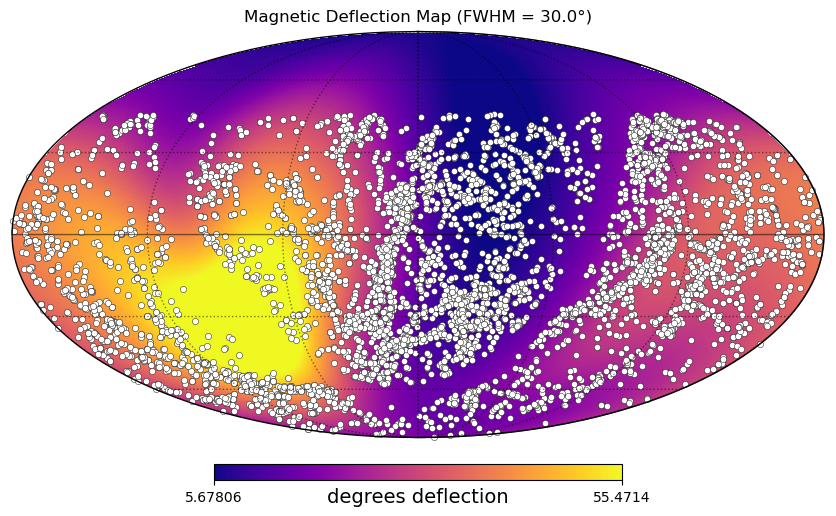

Median deflection = 24.081
Randoms valid after deflection mask: 617700


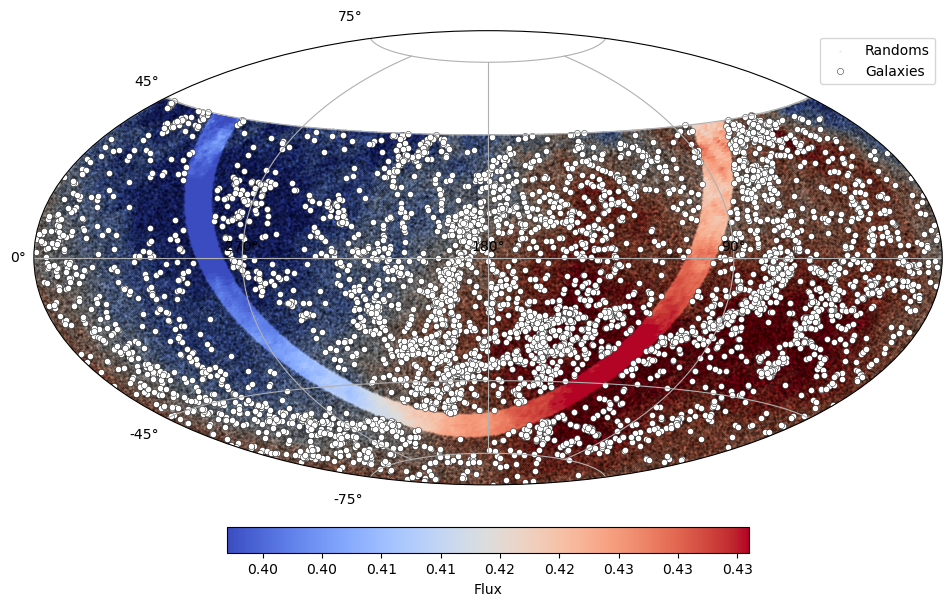

Using npatch = 123 (N_g = 6177)
Built patch_centers shape: (123, 3)
Unique patches assigned: galaxies 123 randoms 123 flux 123
max |xi_unweighted - xi_weighted(ones)| = 0.0
max fractional diff (relative to max xi): 0.0
nk_unweighted npairs[:6]: [ 653050. 1558048. 2434439. 3282280. 4089420. 4853237.]
nk_weighted   npairs[:6]: [ 653050. 1558048. 2434439. 3282280. 4089420. 4853237.]
rk_unweighted npairs[:6]: [6.53038150e+07 1.55996777e+08 2.43448717e+08 3.27039741e+08
 4.06200887e+08 4.80496171e+08]
rk_weighted   npairs[:6]: [6.53038150e+07 1.55996777e+08 2.43448717e+08 3.27039741e+08
 4.06200887e+08 4.80496171e+08]


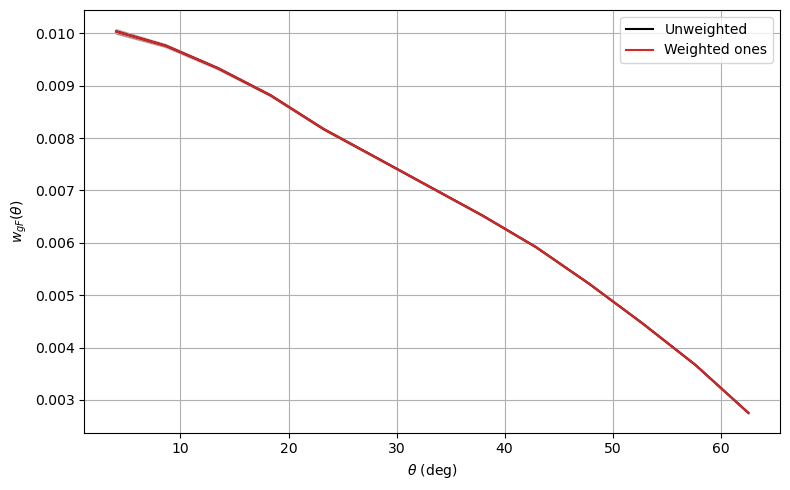

In [21]:
"""
GALAXY–FLUX CORRELATION SPLIT BY MAGNETIC DEFLECTION
"""
def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec']<45.]

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

def plot_magnetic_deflection(deflection_map, gxs_K):
    # === Plot smoothed magnetic deflection map ===
    plt.figure(figsize=(10, 6))
    hp.mollview(
        deflection_map,
        title=f"Magnetic Deflection Map (FWHM = {fwhm_deg:.1f}°)",
        unit="degrees deflection",
        cmap="plasma",
        rot=(180, 0, 0),
        min=np.percentile(deflection_map[deflection_map != hp.UNSEEN], 5),
        max=np.percentile(deflection_map[deflection_map != hp.UNSEEN], 95),
    )
    hp.graticule(dpar=30, dmer=60, alpha=0.5)

    # Overlay galaxies as points
    theta = -np.radians(90 - gxs_K["Dec"])
    phi = np.radians(gxs_K["RA"]) + np.pi
    hp.projscatter(theta, phi, lonlat=False, s=20, color="white", edgecolor='k', linewidth=0.3, alpha=1)

    plt.savefig("../plots/magnetic_deflection_map.png", dpi=300, bbox_inches="tight")
    plt.show()

def plot_catalogues(
    gxs,
    flux_ra, flux_dec, flux_val,
    rand_ra=None, rand_dec=None,
    savepath=None
):

    # if rand_ra and rand_dec is None:
    #     raise ValueError("Both rand_ra and rand_dec must be provided.")
    # if rand_dec and rand_ra is None:
    #     raise ValueError("Both rand_ra and rand_dec must be provided.")
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    # Axes ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])
    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Background flux
    norm_flux = mcolors.Normalize(vmin=np.percentile(flux_val, 5),
                                vmax=np.percentile(flux_val, 95))
    sc = ax.scatter(np.deg2rad(-flux_ra + 180.), np.deg2rad(flux_dec),
                    c=flux_val, s=20, cmap='coolwarm', norm=norm_flux, edgecolor='none', alpha=1)
    cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
    cbar_flux.set_label("Flux")
    cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Randoms
    if rand_ra is not None and rand_dec is not None:
        ax.scatter(np.deg2rad(-rand_ra + 180.), np.deg2rad(rand_dec),
                s=.1, color='black', alpha=0.15, label='Randoms')       

    # Galaxies
    ax.scatter(np.deg2rad(-gxs['RA'] + 180.), np.deg2rad(gxs['Dec']),
            s=20, color='white', edgecolor='k', linewidth=.3, alpha=1, label='Galaxies')

    plt.legend()
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=300)
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.ticker import FormatStrFormatter
import treecorr
import healpy as hp
from astropy.io import ascii
import pandas as pd

# === User parameters ===
defl_file = "../data/JF12_GMFdeflection_Z1_E10EeV.csv"
fwhm_deg = 30.0
nrand = 100

# === Load Galaxies ===
cols = ["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"]
gxs = read_GLADE(cols)
if gxs['RA'].max() <= 2*np.pi:
    gxs['RA'] = np.degrees(gxs['RA'])
    gxs['Dec'] = np.degrees(gxs['Dec'])
    print("Converted RA/Dec from radians to degrees.")
gxs = gxs[gxs['M_K'] < -20.0]  # Apply absolute magnitude cut
gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]  # cz cut

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)
flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]

# === Load / prepare deflection map ===
data = ascii.read(defl_file)
pixel_ids = data['pixid']
deflection_data = data['deflection']
npix = int(np.max(pixel_ids)) + 1
nside = hp.npix2nside(npix)
deflection_map = np.full(npix, hp.UNSEEN)
deflection_map[pixel_ids] = deflection_data

# Smooth map
if fwhm_deg and fwhm_deg > 0:
    fwhm_rad = np.radians(fwhm_deg)
    deflection_map = hp.smoothing(deflection_map, fwhm=fwhm_rad, verbose=False)

# === Assign each galaxy a deflection value ===
theta = np.radians(90 - gxs_K['Dec'])
phi = np.radians(gxs_K['RA'])
pix = hp.ang2pix(nside, theta, phi)
gal_defl = deflection_map[pix]

# Filter out unseen regions
valid = gal_defl != hp.UNSEEN
gxs_K = gxs_K[valid]
gal_defl = gal_defl[valid]


# PLOT DEFLECTION MAP WITH GALAXIES
plot_magnetic_deflection(deflection_map, gxs_K)

median_defl = np.median(gal_defl)

print(f"Median deflection = {median_defl:.3f}")

# === Apply deflection mask to the flux map, exactly like galaxies/randoms ===

# Convert flux RA/Dec to theta/phi
theta_f = np.radians(90 - flux_dec)
phi_f   = np.radians(flux_ra)
pix_f   = hp.ang2pix(nside, theta_f, phi_f)

# Read deflection at flux positions
flux_defl = deflection_map[pix_f]

# Keep only flux points in valid deflection region
valid_f = flux_defl != hp.UNSEEN

flux_dec = flux_dec[valid_f]
flux_ra  = flux_ra[valid_f]
flux_val = flux_val[valid_f]
flux_defl = flux_defl[valid_f]

# === Generate random catalog ===
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*nrand, dec_min=-90, dec_max=45)

# === Apply the deflection mask to the randoms ===
theta_r = np.radians(90 - rand_dec)
phi_r = np.radians(rand_ra)
pix_r = hp.ang2pix(nside, theta_r, phi_r)

rand_defl = deflection_map[pix_r]
valid_r = rand_defl != hp.UNSEEN

# Keep only valid randoms
rand_ra = rand_ra[valid_r]
rand_dec = rand_dec[valid_r]
rand_defl = rand_defl[valid_r]

print(f"Randoms valid after deflection mask: {len(rand_ra)}")

plot_catalogues(gxs_K, flux_ra, flux_dec, flux_val, rand_ra, rand_dec,
    savepath='../plots/skymap_galaxies_deflection.png')

# ---------- begin: stable patching + consistent correlation block ----------

import numpy as np
import treecorr

# 1) Deterministic random subset exactly the size you'll use
N_g = len(gxs_K)
N_rand_needed = N_g * nrand
rand_ra_all = np.asarray(rand_ra, dtype=float)
rand_dec_all = np.asarray(rand_dec, dtype=float)

if len(rand_ra_all) < N_rand_needed:
    raise RuntimeError(f"Not enough randoms after masks: have {len(rand_ra_all)}, need {N_rand_needed}")

rand_ra_sub = rand_ra_all[:N_rand_needed]
rand_dec_sub = rand_dec_all[:N_rand_needed]

# 2) Clean galaxy arrays (force numpy floats)
gal_ra = np.asarray(gxs_K['RA'], dtype=float)
gal_dec = np.asarray(gxs_K['Dec'], dtype=float)

# 3) Choose an npatch that is reasonable: aim ~50 galaxies per patch as a rule of thumb
suggest_npatch = int(min(200, max(10, max(10, N_g // 50))))
npatch = suggest_npatch
print(f"Using npatch = {npatch} (N_g = {N_g})")

# 4) Build base catalog (combined) to get patch_centers (deterministic)
base = treecorr.Catalog(
    ra=np.concatenate([gal_ra, rand_ra_sub]),
    dec=np.concatenate([gal_dec, rand_dec_sub]),
    ra_units='deg', dec_units='deg',
    npatch=npatch
)
patch_centers = base.patch_centers
print("Built patch_centers shape:", np.shape(patch_centers))

# Optional quick sanity: how many patches actually got objects
tmp_g = treecorr.Catalog(ra=gal_ra, dec=gal_dec, ra_units='deg', dec_units='deg', patch_centers=patch_centers)
tmp_r = treecorr.Catalog(ra=rand_ra_sub, dec=rand_dec_sub, ra_units='deg', dec_units='deg', patch_centers=patch_centers)
tmp_f = treecorr.Catalog(ra=np.asarray(flux_ra, dtype=float), dec=np.asarray(flux_dec, dtype=float), ra_units='deg', dec_units='deg', patch_centers=patch_centers)
print("Unique patches assigned: galaxies", np.unique(tmp_g.patch).size, "randoms", np.unique(tmp_r.patch).size, "flux", np.unique(tmp_f.patch).size)

# 5) Clean TreeCorr config (keep your config)
config_local = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc'
}

# 6) Reusable compute function that uses the SAME patch_centers every time
def compute_corr_fixed(gxs, rand_ra_fixed, rand_dec_fixed, flux_ra, flux_dec, flux_val, w_g, w_r, patch_centers):
    """
    gxs: pandas DataFrame (with RA, Dec)
    rand_ra_fixed, rand_dec_fixed: numpy arrays (length N_rand_needed)
    w_g: None or 1D numpy array (len = len(gxs))
    w_r: None or 1D numpy array (len = len(rand_ra_fixed))
    patch_centers: shared patch centers (array of [ra,dec] pairs)
    """
    # force numpy arrays
    gal_ra = np.asarray(gxs['RA'], dtype=float)
    gal_dec = np.asarray(gxs['Dec'], dtype=float)
    rand_ra_fixed = np.asarray(rand_ra_fixed, dtype=float)
    rand_dec_fixed = np.asarray(rand_dec_fixed, dtype=float)
    flux_ra = np.asarray(flux_ra, dtype=float)
    flux_dec = np.asarray(flux_dec, dtype=float)
    flux_val = np.asarray(flux_val, dtype=float)

    # Ensure weight arrays are float64 and correct length (or None)
    if w_g is not None:
        w_g = np.asarray(w_g, dtype=float)
        if len(w_g) != len(gal_ra):
            raise ValueError("w_g length mismatch")
    if w_r is not None:
        w_r = np.asarray(w_r, dtype=float)
        if len(w_r) != len(rand_ra_fixed):
            raise ValueError("w_r length mismatch")

    # Catalogs with identical patch_centers
    gcat = treecorr.Catalog(ra=gal_ra, dec=gal_dec, ra_units='deg', dec_units='deg', w=w_g, patch_centers=patch_centers)
    rand_cat = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed, ra_units='deg', dec_units='deg', w=w_r, patch_centers=patch_centers)
    fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val, ra_units='deg', dec_units='deg', patch_centers=patch_centers)

    nk = treecorr.NKCorrelation(config_local)
    rk = treecorr.NKCorrelation(config_local)

    nk.process(gcat, fcat)
    rk.process(rand_cat, fcat)

    # estimator
    xi = nk.xi / rk.xi - 1
    varxi = nk.varxi / (rk.xi ** 2)

    return nk.meanr, xi, varxi, nk, rk

# 7) Run unweighted (w=None) and weighted (w=ones) with SAME rand slice and SAME patch_centers
w_none = None
w_ones = np.ones(len(gxs_K), dtype=float)
w_r_ones = np.ones(len(rand_ra_sub), dtype=float)

meanr_u, xi_u, var_u, nk_u, rk_u = compute_corr_fixed(gxs_K, rand_ra_sub, rand_dec_sub, flux_ra, flux_dec, flux_val, w_none, None, patch_centers)
meanr_w, xi_w, var_w, nk_w, rk_w = compute_corr_fixed(gxs_K, rand_ra_sub, rand_dec_sub, flux_ra, flux_dec, flux_val, w_ones, w_r_ones, patch_centers)

# 8) Quick comparison
max_abs_xi_diff = np.max(np.abs(xi_u - xi_w))
print("max |xi_unweighted - xi_weighted(ones)| =", max_abs_xi_diff)
print("max fractional diff (relative to max xi):", max_abs_xi_diff / (np.max(np.abs(xi_u)) + 1e-30))

# Debug paircounts if not identical
print("nk_unweighted npairs[:6]:", nk_u.npairs[:6])
print("nk_weighted   npairs[:6]:", nk_w.npairs[:6])
print("rk_unweighted npairs[:6]:", rk_u.npairs[:6])
print("rk_weighted   npairs[:6]:", rk_w.npairs[:6])

# 9) Plot them (same as you had)
results = [
    (meanr_u, xi_u, var_u, 'Unweighted', 'k'),
    (meanr_w, xi_w, var_w, 'Weighted ones', 'C03'),
]

plt.figure(figsize=(8, 5))
for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi), color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ---------- end block ----------

# # === TreeCorr configuration ===
# config = {
#     "min_sep": 1,
#     "max_sep": 65.,
#     "nbins": 13,
#     "sep_units": 'degree',
#     "bin_type": 'Linear',
#     "brute": False,
#     "metric": 'Arc'
#     #"var_method": 'jackknife'
#     #"cross_patch_weight": 'geom'
# }

# # === Compute correlations for all galaxies with/without weights ===
# # --- compute patch_centers once from the *final* galaxy sample (gxs_K) ---
# # print(gxs_K['RA'].max(), rand_ra.max())
# # base = treecorr.Catalog(
# #     ra=np.concatenate([gxs_K['RA'], rand_ra]),
# #     dec=np.concatenate([gxs_K['Dec'], rand_dec]),
# #     ra_units='deg', dec_units='deg',
# #     npatch=200
# # )
# # patch_centers = base.patch_centers

# def compute_corr(
#         gxs, rand_ra, rand_dec,
#         flux_ra, flux_dec, flux_val,
#         weights_bool, label, color
#     ):
#     """
#     Compute galaxy–flux correlation with optional galaxy weights.

#     Parameters
#     ----------
#     gxs : structured array
#         Galaxy catalog with ['RA','Dec'].
#     rand_ra, rand_dec : arrays
#         Random catalog RA/Dec.
#     flux_ra, flux_dec, flux_val : arrays
#         Flux map (scalar field) in RA/Dec/k form.
#     weights_bool : bool
#         If True → use galaxy weights = 1; else → no weights.
#     patch_centers : array
#         Precomputed patch centers (shared for all catalogs).
#     label, color : cosmetic for plotting.

#     Returns
#     -------
#     meanr, xi, varxi, label, color
#     """

#     # --- Galaxy catalog ---
#     if weights_bool:
#         w = np.ones_like(gxs['RA'])
#     else:
#         w = None

#     gcat = treecorr.Catalog(
#         ra=gxs['RA'],
#         dec=gxs['Dec'],
#         ra_units='deg', dec_units='deg',
#         w=w
#     )

#     # --- Random catalog ---
#     # If weights_bool: randoms get w=1; else: w=None
#     if weights_bool:
#         w_r = np.ones_like(rand_ra)
#     else:
#         w_r = None

#     rand_cat = treecorr.Catalog(
#         ra=rand_ra,
#         dec=rand_dec,
#         ra_units='deg', dec_units='deg',
#         w=w_r
#     )

#     # --- Flux catalog ---
#     # No weights here; flux is the scalar field (k array)
#     fcat = treecorr.Catalog(
#         ra=flux_ra,
#         dec=flux_dec,
#         k=flux_val,
#         ra_units='deg', dec_units='deg',
#     )

#     # --- Correlation objects ---
#     nk = treecorr.NKCorrelation(config)
#     rk = treecorr.NKCorrelation(config)

#     nk.process(gcat, fcat)
#     rk.process(rand_cat, fcat)

#     # --- Estimator ---
#     xi = nk.xi / rk.xi - 1
#     varxi = nk.varxi / (rk.xi ** 2)

#     return nk.meanr, xi, varxi, label, color


# results = []

# weights_bool = False
# results.append(compute_corr(
#     gxs_K,
#     rand_ra,
#     rand_dec,
#     flux_ra, flux_dec, flux_val,
#     weights_bool,
#     'Unweighted', 'k'
# ))

# weights_bool = True
# results.append(compute_corr(
#     gxs_K,
#     rand_ra,
#     rand_dec,
#     flux_ra, flux_dec, flux_val,
#     weights_bool,
#     'Weighted', 'C03'
# ))

# # === Plot correlation functions ===
# plt.figure(figsize=(8, 5))
# for meanr, xi, varxi, label, color in results:
#     plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
#                      color=color, alpha=0.2)
#     plt.plot(meanr, xi, color=color, label=label)
# plt.xlabel(r'$\theta$ (deg)')
# plt.ylabel(r'$w_{gF}(\theta)$')
# plt.grid()
# plt.legend(loc='upper right')
# plt.tight_layout()
# #plt.savefig('../plots/gal_flux_correlation_deflection.png', dpi=300)
# plt.show()


/tmp/ipykernel_14870/2413908668.py:67: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(
/tmp/ipykernel_14870/2413908668.py:116: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  dmap = hp.smoothing(dmap, fwhm=np.radians(fwhm_deg), verbose=False)


<Figure size 1000x700 with 0 Axes>

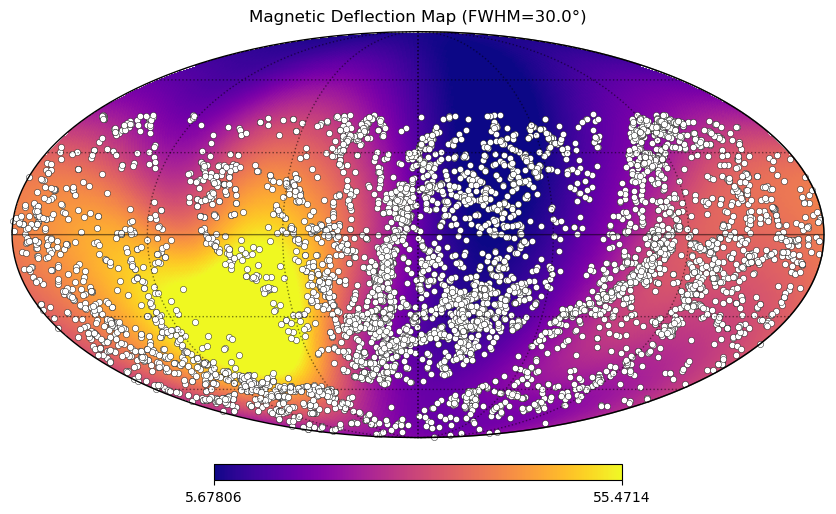

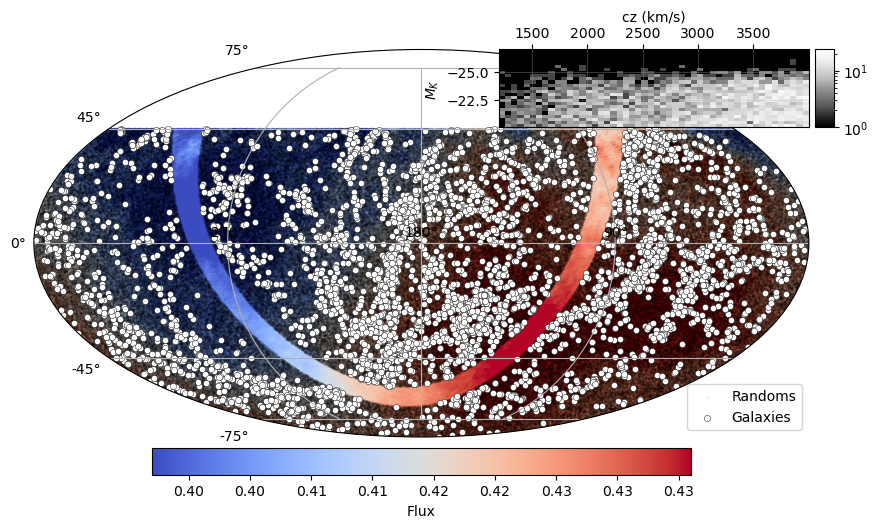

Using npatch = 123


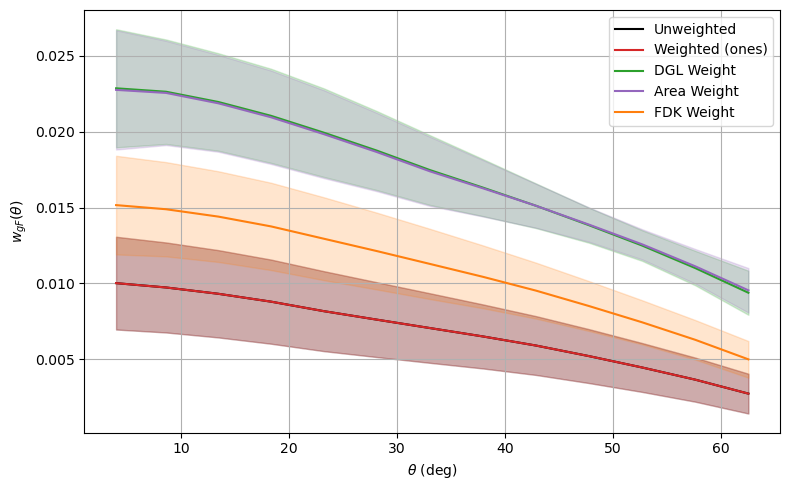

In [3]:
"""
Cleaned galaxy-flux correlation script with optional galaxy weights
(applies JF12 deflection map-derived weights to galaxies only).

Usage:
  - Edit file paths at the top if needed.
  - Run in an environment with treecorr, healpy, astropy, pandas, numpy, matplotlib.

Notes:
  - The `compute_weight_from_deflection` function is a placeholder: replace with
    the exact mapping you want from JF12 deflection to galaxy weight.
  - This script uses a deterministic subset of randoms and a fixed set of
    patch_centers so weighted/unweighted runs are consistent.

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.ticker import FormatStrFormatter
import healpy as hp
import treecorr
from astropy.io import ascii


# --------------------------- User parameters ---------------------------
GLADE_FILE = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
DEFL_FILE = "../data/JF12_GMFdeflection_Z1_E10EeV.csv"
FLUX_FILE = "../data/Auger/flux_a8_lb.dat"
PLOTS_DIR = "../plots"

FWHM_DEG = 30.0  # smoothing for deflection map
N_RAND_PER_GAL = 100
MIN_CZ = 1200
MAX_CZ = 4000
MK_CUT = -20.0
MAX_DEC = 45.0

# TreeCorr configuration (NK correlation)
TC_CONFIG = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'jackknife',
    "cross_patch_weight": 'simple'
}


# --------------------------- Helper functions ---------------------------

def read_GLADE(cols_to_use, cz_min=MIN_CZ, dL_max=200, filename=GLADE_FILE):
    from get_masks import get_milkyway_mask

    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"]) & np.isfinite(chunk["RA"]) & np.isfinite(chunk["Dec"]) 
        filtered_chunks.append(chunk.loc[mask])

    df = pd.concat(filtered_chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    # apply Milky Way mask and dec cut
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec'] < MAX_DEC]

    return df


def generate_RanCat(N_total, dec_min=-90, dec_max=MAX_DEC):
    from get_masks import get_milkyway_mask

    rand_ra = np.random.uniform(0, 360, N_total * 3)
    rand_sindec = np.random.uniform(np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total * 3)
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError("Not enough random points generated after masking")
    return rand_ra, rand_dec


def load_deflection_map(defl_file=DEFL_FILE, fwhm_deg=FWHM_DEG):
    data = ascii.read(defl_file)
    pixel_ids = np.asarray(data['pixid'], dtype=int)
    deflection_data = np.asarray(data['deflection'], dtype=float)
    npix = int(np.max(pixel_ids)) + 1
    nside = hp.npix2nside(npix)
    dmap = np.full(npix, hp.UNSEEN, dtype=float)
    dmap[pixel_ids] = deflection_data
    if fwhm_deg and fwhm_deg > 0:
        dmap = hp.smoothing(dmap, fwhm=np.radians(fwhm_deg), verbose=False)
    return dmap, nside


def compute_weight_from_deflection(defl_values):
    """
    Convert deflection (degrees) into a weight for galaxies.
    Replace this mapping with the desired relation.
    Current placeholder: weight = 1 / (1 + defl) normalized to mean=1.
    """
    # Placeholder
    # w = 1.0 / (1.0 + np.abs(defl_values))

    # DGL Weighting Scheme
    sigma = np.mean(defl_values**2)**0.5
    w = 1. / ((sigma/20.)**2+defl_values**2)#**0.5
    w_a = w / np.mean(w)

    # Area weighting
    w = 1. / defl_values**2
    w_b = w / np.mean(w)

    # FDK Weighting scheme
    w = 1. / (1 + (defl_values-defl_values.min()))**.5 
    w_c = w / np.mean(w)


    # Alternative: robust inverse-variance weighting
    #eps = 1e-6
    #sigma0 = 0.1 * np.median(defl_values)   # floor = 10% of median (tune if needed)
    #w_raw = 1.0 / (defl_values**2 + sigma0**2)
    #w = w_raw / np.mean(w_raw)

    # normalize to mean=1 so total weight scale is comparable to unweighted
    # w = w / np.mean(w)
    return w_a, w_b, w_c


def plot_moll_deflection(dmap, fwhm_deg, galaxies=None, savepath=None):
    vmin = np.percentile(dmap[dmap != hp.UNSEEN], 5)
    vmax = np.percentile(dmap[dmap != hp.UNSEEN], 95)
    plt.figure(figsize=(10, 7))
    hp.mollview(dmap, title=f"Magnetic Deflection Map (FWHM={fwhm_deg}°)", cmap='plasma', rot=(180, 0, 0), min=vmin, max=vmax)
    hp.graticule(dpar=30, dmer=60, alpha=0.5)
    if galaxies is not None:
        theta = -np.radians(90 - galaxies['Dec'])
        phi = np.radians(galaxies['RA']) + np.pi
        hp.projscatter(theta, phi, s=20, color='white', edgecolor='k', linewidth=0.3)
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()   

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter

def plot_catalogues(
    gxs,
    flux_ra, flux_dec, flux_val,
    rand_ra=None, rand_dec=None,
    savepath=None
):
    plt.figure(figsize=(10, 7))
    ax = plt.subplot(111, projection='mollweide')
    ax.grid(True)

    # Axes ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])
    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Background flux
    p5, p95 = np.percentile(flux_val, [5, 95])
    norm_flux = mcolors.Normalize(vmin=p5, vmax=p95)
    sc = ax.scatter(
        np.deg2rad(-flux_ra + 180.), np.deg2rad(flux_dec),
        c=flux_val, s=20, cmap='coolwarm',
        norm=norm_flux, edgecolor='none', alpha=1
    )
    cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal',
                             pad=0.02, fraction=0.05)
    cbar_flux.set_label("Flux")
    cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Randoms
    if rand_ra is not None and rand_dec is not None:
        ax.scatter(
            np.deg2rad(-rand_ra + 180.), np.deg2rad(rand_dec),
            s=0.1, color='black', alpha=0.15, label='Randoms'
        )

    # Galaxies
    ax.scatter(
        np.deg2rad(-gxs['RA'] + 180.), np.deg2rad(gxs['Dec']),
        s=20, color='white', edgecolor='k', linewidth=0.3,
        alpha=1, label='Galaxies'
    )

    plt.legend(loc='lower right')

    # ============================
    #   INSERTED INSET PLOT HERE
    # ============================
    inset = inset_axes(ax, width="40%", height="20%",
                       loc='upper right', borderpad=0)

    # SCATTER
    # inset.scatter(gxs['cz'], gxs['M_K'], s=10,
    #               color='tab:blue', alpha=0.7, edgecolor='none')

    # 2D HISTOGRAM
    hist = inset.hist2d(
        gxs['cz'], gxs['M_K'], bins=(50, 25),
        cmap='Greys_r',
        norm=mcolors.LogNorm()
    )

    inset.set_facecolor('k')
    # hist[3] is the QuadMesh that the colorbar needs
    cax = inset.inset_axes([1.02, 0.0, 0.06, 1.0]) 
    cbar_inset = plt.colorbar(hist[3], cax=cax, orientation='vertical', pad=0.0, fraction=.5)
    #cbar_inset = plt.colorbar(hist[3], ax=inset, orientation='vertical')

    inset.set_xlabel("cz (km/s)", fontsize=10)
    inset.set_ylabel(r"$M_K$", fontsize=10)
    inset.tick_params(labelsize=10)
    inset.invert_yaxis()  # optional: magnitudes brighter at top

    inset.xaxis.tick_top()
    inset.xaxis.set_label_position('top')

    inset.grid(alpha=0.3)

    # Tight layout + save
    #plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()


def plot_results(meanr_list, xi_list, var_list, labels, colors, savepath=None):
    plt.figure(figsize=(8, 5))
    for meanr, xi, varxi, lab, col in zip(meanr_list, xi_list, var_list, labels, colors):
        plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi), color=col, alpha=0.2)
        plt.plot(meanr, xi, color=col, label=lab)
    plt.xlabel(r'$\theta$ (deg)')
    plt.ylabel(r'$w_{gF}(\theta)$')
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()


# --------------------------- Main processing ---------------------------

def main():
    # load galaxies
    cols = ["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"]
    gxs = read_GLADE(cols)
    if gxs['RA'].max() <= 2 * np.pi:
        gxs['RA'] = np.degrees(gxs['RA'])
        gxs['Dec'] = np.degrees(gxs['Dec'])

    gxs = gxs[gxs['M_K'] < MK_CUT]
    gxs_K = gxs[(gxs['cz'] >= MIN_CZ) & (gxs['cz'] <= MAX_CZ)].reset_index(drop=True)

    # load flux
    flux_cat = np.loadtxt(FLUX_FILE)
    flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]

    # load deflection map and assign to galaxies
    deflection_map, nside = load_deflection_map()
    theta = np.radians(90 - gxs_K['Dec'])
    phi = np.radians(gxs_K['RA'])
    pix = hp.ang2pix(nside, theta, phi)
    gal_defl = deflection_map[pix]
    valid = gal_defl != hp.UNSEEN
    gxs_K = gxs_K[valid].reset_index(drop=True)
    gal_defl = gal_defl[valid]

    # plot deflection with galaxies
    plot_moll_deflection(deflection_map, FWHM_DEG, galaxies=gxs_K, savepath=f"{PLOTS_DIR}/mag_def_map.png")

    # Apply same deflection mask to flux
    theta_f = np.radians(90 - flux_dec)
    phi_f = np.radians(flux_ra)
    pix_f = hp.ang2pix(nside, theta_f, phi_f)
    flux_defl = deflection_map[pix_f]
    valid_f = flux_defl != hp.UNSEEN
    flux_ra = flux_ra[valid_f]
    flux_dec = flux_dec[valid_f]
    flux_val = flux_val[valid_f]

    # generate randoms and apply same deflection mask
    rand_ra_all, rand_dec_all = generate_RanCat(len(gxs_K) * N_RAND_PER_GAL)
    theta_r = np.radians(90 - rand_dec_all)
    pix_r = hp.ang2pix(nside, theta_r, np.radians(rand_ra_all))
    rand_defl = deflection_map[pix_r]
    valid_r = rand_defl != hp.UNSEEN
    rand_ra_all = rand_ra_all[valid_r]
    rand_dec_all = rand_dec_all[valid_r]

    # plot catalogues after deflection mask
    plot_catalogues(gxs_K, flux_ra, flux_dec, flux_val, rand_ra_all, rand_dec_all,
        savepath=f'{PLOTS_DIR}/skymap_galaxies_deflection.png')
    
    # deterministic subset to exactly N_g * N_RAND_PER_GAL
    N_g = len(gxs_K)
    N_rand_needed = N_g * N_RAND_PER_GAL
    if len(rand_ra_all) < N_rand_needed:
        raise RuntimeError("Not enough randoms after deflection mask")
    rand_ra_sub = np.asarray(rand_ra_all[:N_rand_needed], dtype=float)
    rand_dec_sub = np.asarray(rand_dec_all[:N_rand_needed], dtype=float)

    # prepare arrays for TreeCorr
    gal_ra = np.asarray(gxs_K['RA'], dtype=float)
    gal_dec = np.asarray(gxs_K['Dec'], dtype=float)
    flux_ra = np.asarray(flux_ra, dtype=float)
    flux_dec = np.asarray(flux_dec, dtype=float)
    flux_val = np.asarray(flux_val, dtype=float)

    # choose npatch reasonably
    suggest_npatch = int(min(200, max(10, max(10, N_g // 50))))
    print('Using npatch =', suggest_npatch)
    base = treecorr.Catalog(ra=np.concatenate([gal_ra, rand_ra_sub]),
                             dec=np.concatenate([gal_dec, rand_dec_sub]),
                             ra_units='deg', dec_units='deg', npatch=suggest_npatch)
    patch_centers = base.patch_centers

    # compute weight array from deflection (galaxies only)
    w_gal_a, w_gal_b, w_gal_c = compute_weight_from_deflection(gal_defl)
    w_rand = np.ones(len(rand_ra_sub), dtype=float)  # randoms get unit weight

    # define reusable compute function (fixed patch_centers)
    def compute_corr_fixed(gal_ra, gal_dec, w_g, \
                           rand_ra_fixed, rand_dec_fixed, w_r, \
                            flux_ra, flux_dec, flux_val, patch_centers):
        gcat = treecorr.Catalog(ra=gal_ra, dec=gal_dec, \
                                ra_units='deg', dec_units='deg', w=w_g, \
                                    patch_centers=patch_centers)
        rand_cat = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed, \
                                    ra_units='deg', dec_units='deg', w=w_r, \
                                        patch_centers=patch_centers)
        fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val, \
                                ra_units='deg', dec_units='deg')

        nk = treecorr.NKCorrelation(TC_CONFIG)
        rk = treecorr.NKCorrelation(TC_CONFIG)

        nk.process(gcat, fcat)
        rk.process(rand_cat, fcat)

        xi = nk.xi / rk.xi - 1
        varxi = nk.varxi / (rk.xi ** 2)
        return nk.meanr, xi, varxi, nk, rk

    # run unweighted and weighted(ones) and weighted(deflection)
    meanr_u, xi_u, var_u, nk_u, rk_u = compute_corr_fixed(gal_ra, gal_dec, None,
                                                           rand_ra_sub, rand_dec_sub, None,
                                                           flux_ra, flux_dec, flux_val, patch_centers)

    meanr_w1, xi_w1, var_w1, nk_w1, rk_w1 = compute_corr_fixed(gal_ra, gal_dec, np.ones_like(gal_ra, dtype=float),
                                                                rand_ra_sub, rand_dec_sub, w_rand,
                                                                flux_ra, flux_dec, flux_val, patch_centers)

    meanr_wdef_a, xi_wdef_a, var_wdef_a, nk_wdef_a, rk_wdef_a = compute_corr_fixed(gal_ra, gal_dec, w_gal_a,
                                                                         rand_ra_sub, rand_dec_sub, w_rand,
                                                                         flux_ra, flux_dec, flux_val, patch_centers)

    meanr_wdef_b, xi_wdef_b, var_wdef_b, nk_wdef_b, rk_wdef_b = compute_corr_fixed(gal_ra, gal_dec, w_gal_b,
                                                                         rand_ra_sub, rand_dec_sub, w_rand,
                                                                         flux_ra, flux_dec, flux_val, patch_centers)

    meanr_wdef_c, xi_wdef_c, var_wdef_c, nk_wdef_c, rk_wdef_c = compute_corr_fixed(gal_ra, gal_dec, w_gal_c,
                                                                         rand_ra_sub, rand_dec_sub, w_rand,
                                                                         flux_ra, flux_dec, flux_val, patch_centers)
       
    # compare
    # max_abs_xi_diff = np.max(np.abs(xi_u - xi_w1))
    # when using ones weights we expect exact equality (within floating errors)

    # plotting
    meanr_list = [meanr_u, meanr_w1, meanr_wdef_a, meanr_wdef_b, meanr_wdef_c]
    xi_list = [xi_u, xi_w1, xi_wdef_a, xi_wdef_b, xi_wdef_c]
    var_list = [var_u, var_w1, var_wdef_a, var_wdef_b, var_wdef_c]
    labels = ["Unweighted", "Weighted (ones)", "DGL Weight", "Area Weight", "FDK Weight"]
    colors = ['k', 'C3', 'C2', 'C4', 'C1']

    plot_results(meanr_list, xi_list, var_list, labels, colors, savepath=f"{PLOTS_DIR}/gal_flux_corrs.png")


if __name__ == '__main__':
    main()
